# Compute BlocRes Evaluation

In [1]:
import os
from pathlib import Path

import scipion_bridge
import scipion_bridge.ffi.scipion as scipion
# from scipion_bridge.ffi.blocres import blocres
# from scipion_bridge.proxy import OutputInfo

import shutil

from utils import download as D
scipion_bridge.utils.environment.configure_default_env()

import matplotlib.pyplot as plt

### Download Data

In [2]:
DOWNLOAD_PATH = Path("data/downloaded")
EMDB_ENTRY = 41510

In [3]:
metadata = D.download_emdb_metadata(entry_id=EMDB_ENTRY)

os.makedirs(DOWNLOAD_PATH, exist_ok=True)

emdb_map = D.download_emdb_map(EMDB_ENTRY, DOWNLOAD_PATH)
map_1, map_2 = D.download_halfmaps(EMDB_ENTRY, DOWNLOAD_PATH)
pdb_model = D.download_pdb_model("8tqo", DOWNLOAD_PATH) # metadata.pdb_id

metadata

EMDBMetadata(pdb_id='7l70', resolution=3.1, sampling=0.835, size=256, org_x=0, org_y=0, org_z=0)

### Create Volume from PDB

In [6]:
volume = scipion.xmipp_volume_from_pdb(
    pdb_model,
    center_pdb="-v 0",
    sampling=metadata.sampling,
    size=metadata.size,
).typed(astype=scipion.SpiderFile)

volume = scipion.xmipp_volume_align(
    embdb_map=emdb_map,
    volume=volume,
    local=True,
)

volume

[XMIPP] scipion run xmipp_volume_from_pdb -i data/downloaded/pdb8tqo.ent -o /tmp/tmp03r3o4ac --centerPDB -v 0 --sampling 0.835 --size 256
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_volume_align --i1 data/downloaded/emd_41510.map --i2 /tmp/tmp03r3o4ac.vol --local --apply /tmp/tmp8t6w7f08.vol
1 (1,0,0,0,0,1,0,0,0)--->-0.349795
   (1,0,***0.709587,0,0,1,0,0,0)--->-0.354899
   (1,0,0.709587,***0.889898,0,1,0,0,0)--->-0.359015
   (1,0,0.709587,0.889898,***-2.02647,1,0,0,0)--->-0.364126
   (1,0,0.709587,0.889898,-2.02647,***1.0526,0,0,0)--->-0.372631
   (1,0,0.709587,0.889898,-2.02647,1.0526,***-4.86482,0,0)--->-0.388258
   (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,***3.64532,0)--->-0.465488
   (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,3.64532,***2.76693)--->-0.558715
2 (1,0,0.709587,0.889898,-2.02647,1.0526,-4.86482,3.64532,2.76693)--->-0.558715
   (1,0,***2.07012,0.889898,-2.02647,1.0526,-4.86482,3.64532,2.76693)--->-0.576119
   (1,0,2.07012,***0

In [5]:
os.path.exists(volume.path)
os.path.getsize(volume.path)

67109888

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

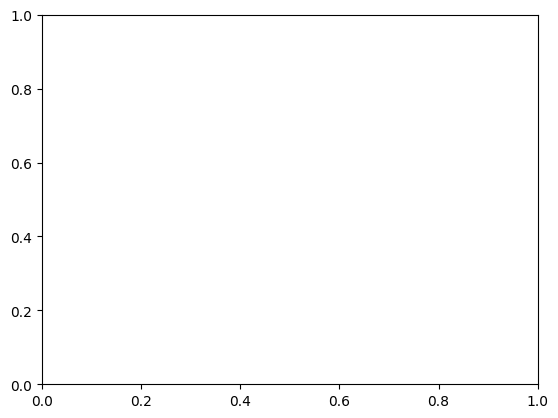

In [7]:
import numpy as np
thresholded = np.array(volume) > 0.0

plt.hist(np.reshape(thresholded, [-1]))

In [ ]:
# [XMIPP] scipion run xmipp_volume_align --i1 data/downloaded/emd_41510.map --i2 /tmp/tmpvmzz70hb --local --apply /tmp/tmp09zqxngg.vol

In [6]:
print(volume.path)

/tmp/tmpi0j_6yop.vol


In [5]:
volume.file_ext()

### Mask from Volume

In [5]:
mask = scipion.xmipp_transform_threshold(
    volume, select="below 0.02", substitute="binarize"
)
mask = scipion.xmipp_transform_morphology(mask, binary_operation="dilation", size=2)

mask

[XMIPP] scipion run xmipp_transform_threshold -i /tmp/tmpih2qynru.vol -o /tmp/tmppksnirse.vol --select below 0.02 --substitute binarize
Input File: /tmp/tmpih2qynru.vol
Output File: /tmp/tmppksnirse.vol
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_transform_morphology -i /tmp/tmppksnirse.vol -o /tmp/tmpla1dvahv.vol --binaryOperation dilation --size 2
Input File: /tmp/tmppksnirse.vol
Output File: /tmp/tmpla1dvahv.vol
Initially the image has 487083 pixels set to 1
Finally the image has 646612 pixels set to 1
Xmipp command detected
Scipion v3.7.1 - Eugenius


Output()

In [6]:
def apply_sampling(data, sampling):
    data = scipion.xmipp_image_convert(data)
    scipion.xmipp_image_header(data, sampling=sampling)

    return data

volume = apply_sampling(volume, metadata.sampling)
mask = apply_sampling(mask, metadata.sampling)

[XMIPP] scipion run xmipp_image_convert -i /tmp/tmpih2qynru.vol -o /tmp/tmprqtfitwb.mrc -t vol
Input File: /tmp/tmpih2qynru.vol
Output File: /tmp/tmprqtfitwb.mrc
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_header -i /tmp/tmprqtfitwb.mrc -s 0.835
Input File: /tmp/tmprqtfitwb.mrc
New sampling rate (Angstrom) = 0.835
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_convert -i /tmp/tmpla1dvahv.vol -o /tmp/tmpjvct5xl5.mrc -t vol
Input File: /tmp/tmpla1dvahv.vol
Output File: /tmp/tmpjvct5xl5.mrc
Xmipp command detected
Scipion v3.7.1 - Eugenius
[XMIPP] scipion run xmipp_image_header -i /tmp/tmpjvct5xl5.mrc -s 0.835
Input File: /tmp/tmpjvct5xl5.mrc
New sampling rate (Angstrom) = 0.835
Xmipp command detected
Scipion v3.7.1 - Eugenius


### Compute BlocRes

In [7]:
blocres_half = blocres(
    str(map_1),
    str(map_2),
    mask=mask,
    sampling=f"{metadata.sampling} {metadata.sampling} {metadata.sampling}",
    box=int(metadata.resolution * 6),
    cutoff=0.5,
    step=1,
    verbose=1,
)

[BlocRes] /home/max/scipion3/software/em/bsoft/bin/blocres  -Mask /tmp/tmpjvct5xl5.mrc -sampling 0.835 0.835 0.835 -box 18 -cutoff 0.5 -nofill -smooth -pad 1 -step 1 -maxresolution 0.5 -verbose 1 data/downloaded/emd_41510_half_map_1.map data/downloaded/emd_41510_half_map_2.map /tmp/tmpunxxt95c.map
# /home/max/scipion3/software/em/bsoft/bin/blocres -Mask /tmp/tmpjvct5xl5.mrc -sampling 0.835 0.835 0.835 -box 18 -cutoff 0.5 -nofill -smooth -pad 1 -step 1 -maxresolution 0.5 -verbose 1 data/downloaded/emd_41510_half_map_1.map data/downloaded/emd_41510_half_map_2.map /tmp/tmpunxxt95c.map 
# Wed Jul 16 13:15:13 2025


Calculating local resolution:
Mask:                           /tmp/tmpjvct5xl5.mrc (-1)
Kernel size:                    18
Step size:                      1
Edge size:                      9	9	9
Padding size:                   36
Smoothing/tapering:             2
Cutoff(s):                      0.500

Boxes to calculate:             646612

Boxes calculated:               646612

In [8]:
atomic_model = scipion.xmipp_pdb_label_from_volume(
    pdb=str(pdb_model),
    volume=blocres_half,
    mask=mask,
    sampling=metadata.sampling,
    origin="%f %f %f" % (metadata.org_x, metadata.org_y, metadata.org_z),
)

shutil.copy(atomic_model.path, f"data/blocres_result_{EMDB_ENTRY}.pdb")

[XMIPP] scipion run xmipp_pdb_label_from_volume -o /tmp/tmp7efz7quw.atom.pdb --pdb data/downloaded/pdb8tqo.ent --vol /tmp/tmpcwzph5sb.map --mask /tmp/tmpcub3ywqh.mrc --sampling 0.835 --origin 0.000000 0.000000 0.000000
PDB file:           data/downloaded/pdb8tqo.ent
Output:       /tmp/tmp7efz7quw.atom.pdb
Sampling rate:        0.835
Origin:               0.000000 0.000000 0.000000 
Radius:               0.8
mean value: = 3.2293
absolute mean value: = 3.2293
Xmipp command detected
Scipion v3.7.1 - Eugenius


'data/blocres_result_41510.pdb'